# Fetch and load PDB
This code acquires the pdb file from the RCSB databank, loads the necessary information, and saves copies for possible use in visualization in other software.

In [1]:
from pyCapsid.PDB import getCapsid
pdb = '4oq8'
capsid, calphas, coords, bfactors, chain_starts, title = getCapsid(pdb, save=True)

Fetching file 1 / 1 (4oq8)...
Done


@> 1810 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 72 residues.
@> Biomolecular transformations were applied to the coordinate data.
@> 1810 atoms and 1 coordinate set(s) were parsed in 0.02s.


Number Of Residues:  8640
Writing complete capsid PDB


@> WARNING hybrid36 format is being used


# Build ENM Hessian
This code builds a hessian matrix using an elastic network model defined by the given parameters. The types of model and the meaning of the parameters are provided in the documentation.

In [2]:
from pyCapsid.ENM import buildENMPreset
kirch, hessian = buildENMPreset(coords, preset='U-ENM')

Building hessian for model preset:  U-ENM
Model parameters:  {'cutoff': 7.5, 'gnm': False, 'fanm': 0.1, 'wfunc': 'power', 'base_dist': 1, 'd_power': 0, 'backbone': False, 'k_backbone': 1, 'l_backbone': 1, 'chain_starts': None}
Finding neighbors within 7.5Å
Building kirchhoff matrix
Building hessian matrix
Done building model


# Perform NMA
## Calculate low frequency modes
This code calculates the n lowest frequency modes of the system by calculating the eigenvalues and eigenvectors of the hessian matrix.

In [3]:
from pyCapsid.NMA import modeCalc
n_modes = 100
eigmethod = 'eigsh'

evals, evecs = modeCalc(hessian, n_modes, eigmethod=eigmethod)

Calculating Normal Modes
NMA time:  23.308406829833984


## Predict, fit, and compare b-factors
This code uses the resulting normal modes and frequencies to predict the b-factors of each alpha carbon, fits these results to experimental values from the pdb entry, and plots the results for comparison.

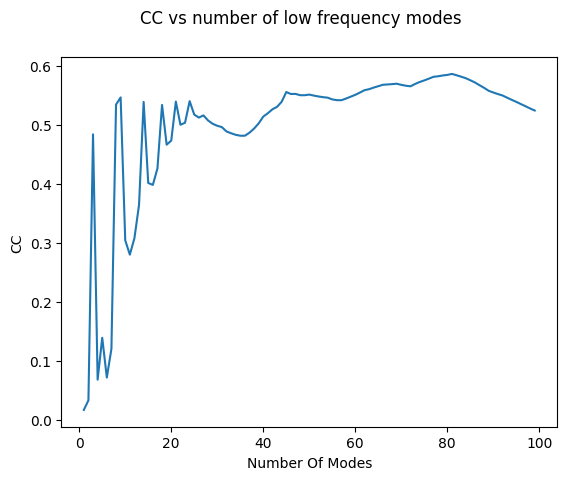

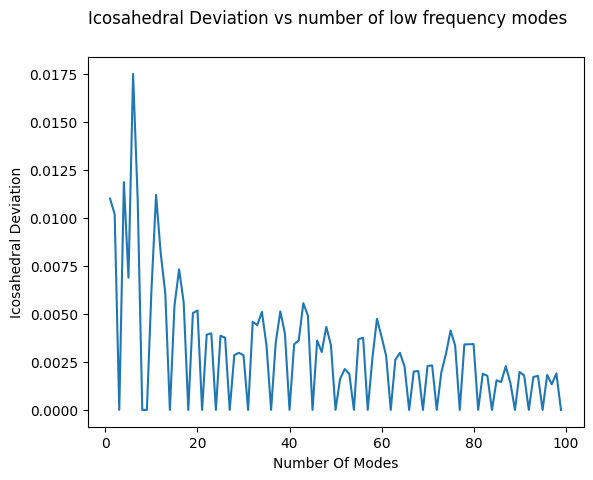

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                 8640
Model:                            RLM   Df Residuals:                     8639
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 06 Feb 2023                                         
Time:                        17:07:51                                         
No. Iterations:                    15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           146.9901      0.103   1423.254      0.0

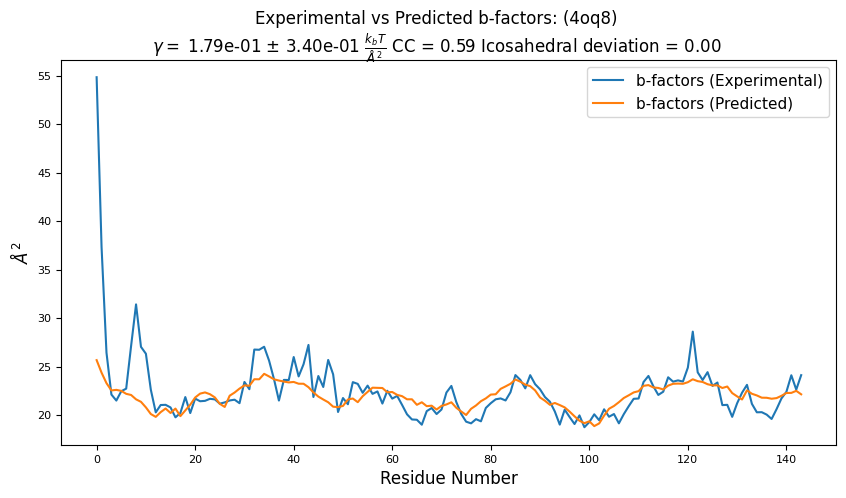

(0.5864215933948872,
 146.99009274201111,
 0,
 array([25.6595017 , 24.36744804, 23.28378875, ..., 22.39819479,
        22.59809181, 22.21802877]),
 0.3397527616207867,
 array([0.]),
 1.960261286626519e-09,
 80)

In [4]:
from pyCapsid.bfactorfit import plotBfactors
plotBfactors(evals, evecs, bfactors, pdb, is3d=True, fitModes=True, plotModes=True, forceIco=False, icotol=0.002)

# Perform quasi-rigid cluster identification (QRC)
## Build weighted graph based on distance fluctuations
This code calculates the distance fluctuations between residues within a cutoff distance from each other and transforms those distance fluctuations into a similarity matrix representing a sparse weighted graph.

In [5]:
from pyCapsid.NMA import calcDistFlucts

fluct_cutoff = 10

dist_flucts = calcDistFlucts(evals, evecs, n_modes, coords, fluct_cutoff, is3d=True)
print(dist_flucts.data)

100
Direct Calculation Method
diag:  [0.18428078 0.17413403 0.16521141 ... 0.15783725 0.15996395 0.15730318]
data:  [0.17425141 0.16782446 0.16233131 ... 0.15783725 0.15996395 0.15730318]
[0.00098938 0.00685998 0.02063162 ... 0.         0.         0.        ]
[0.00098938 0.00685998 0.02063162 ... 0.         0.         0.        ]


## Calculate the spectral embedding of the graph
This code calculates the spectral embedding (eigenvectors) of the sparse weighted graph.

RMS distance fluctuations:  0.06231583316218979
Performing Spectral Embedding
(1, array([0, 0, 0, ..., 0, 0, 0]))
Clustering Embedded Points
Clusters: 4
discretize
(4,)
Scoring
Score:  2.878472582065398
Clusters: 6
discretize
(6,)
Scoring
Score:  3.366178179934944
Clusters: 8
discretize
(8,)
Scoring
Score:  3.2331692090821025
Clusters: 10
discretize
(10,)
Scoring
Score:  3.785274537133914
Clusters: 12
discretize
(12,)
Scoring
Score:  4.206901658896433
Clusters: 14
discretize
(14,)
Scoring
Score:  3.496591366015277
Clusters: 16
discretize
(16,)
Scoring
Score:  2.8066762487111854
Clusters: 18
discretize
(18,)
Scoring
Score:  3.204170225085922
Clusters: 20
discretize
(20,)
Scoring
Score:  3.692250499191549
Clusters: 22
discretize
(22,)
Scoring
Score:  3.189680496135275
Clusters: 24
discretize
(24,)
Scoring
Score:  3.0398401388486684
Clusters: 26
discretize
(26,)
Scoring
Score:  3.1748451596537297
Clusters: 28
discretize
(28,)
Scoring
Score:  3.501784439586946
Clusters: 30
discretize
(30,)

C:\Users\colin\miniconda3\envs\pycapsid_local\lib\site-packages\pyCapsid\clustering_util.py:94: RuntimeWarning: divide by zero encountered in divide
  s = a / b


(44,)
Scoring
Score:  3.731658770916728
Clusters: 46
discretize
(46,)
Scoring
Score:  3.795483742562885
Clusters: 48
discretize
(48,)
Scoring
Score:  3.823017945037026
Clusters: 50
discretize
(50,)
Scoring
Score:  3.7741201100935626
Clusters: 52
discretize
(52,)
Scoring
Score:  4.217612739489524
Clusters: 54
discretize
Some clusters unassigned
Assigned Clusters:  53
(53,)
Scoring
Score:  4.472627841640732
Clusters: 56
discretize
Some clusters unassigned
Assigned Clusters:  55
(55,)
Scoring
Score:  5.070926855027788
Clusters: 58
discretize
(58,)
Scoring
Score:  6.427047135318542
Clusters: 60
discretize
Some clusters unassigned
Assigned Clusters:  59
(59,)
Scoring


C:\Users\colin\miniconda3\envs\pycapsid_local\lib\site-packages\pyCapsid\clustering_util.py:94: RuntimeWarning: divide by zero encountered in divide
  s = a / b


Score:  5.065730531148546
Plotting


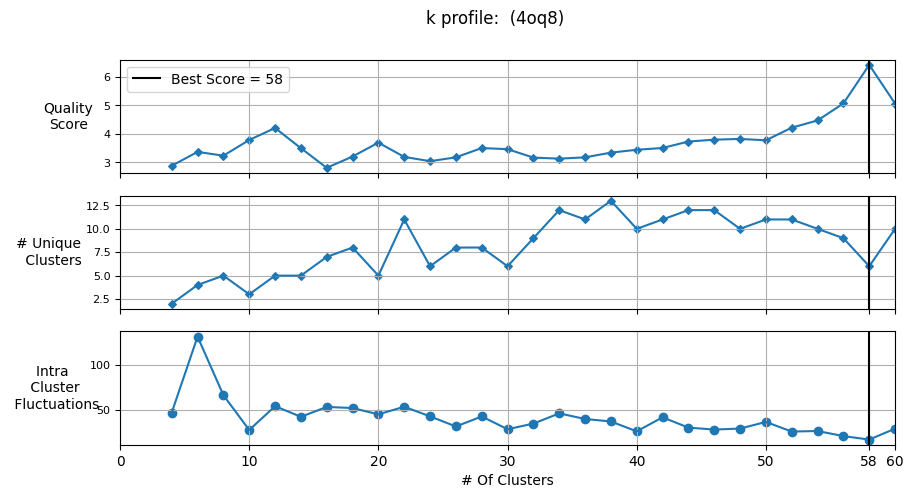

In [6]:
from pyCapsid.QRC import findQuasiRigidClusters
import numpy as np
n_cluster_max = 62
n_range = np.arange(4, n_cluster_max, 2)
labels, score  = findQuasiRigidClusters(pdb, dist_flucts, n_range)

In [7]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pyCapsid.viz_util import chimeraxLaunchTest
import os
print(os.getcwd())
chimeraxLaunchTest(labels, pdb_path = '../notebooks/7kq5_capsid.pdb', labels_path='C:/Users/colin/test.npy')

C:\Users\colin\pyCapsid\notebooks
C:/Users/colin/test.npy
C:\Program Files\ChimeraX\bin\ChimeraX.exe
""C:\Program Files\ChimeraX\bin\ChimeraX.exe" --script "../src/pyCapsid/scripts/chimerax_script.py C:/Users/colin/test.npy . ../notebooks/7kq5_capsid.pdb""


In [10]:
from pyCapsid.viz_util import Molecule
from pyCapsid.viz_util import generate_colormap

In [11]:
with open(pdb + "_capsid.pdb") as ifile:
    mol = Molecule(ifile)

In [12]:
import numpy as np
print(np.min(labels))
print('labels: ', labels.shape)

0
labels:  (15900,)


In [13]:
import matplotlib as mpl
clusters = labels
norm = mpl.colors.Normalize(vmin=np.min(clusters), vmax=np.max(clusters))
cmap = generate_colormap(int(np.max(clusters)))
print(cmap)
rgba = cmap(norm(clusters))
print(rgba*255)
hexcolor = []
for c in rgba:
    hexcolor.append(mpl.colors.rgb2hex(c))

[[  0.         138.42857143  72.6240536  255.        ]
 [  0.         138.42857143  72.6240536  255.        ]
 [ 33.78999379 109.28571429   0.         255.        ]
 ...
 [ 80.14285714  66.82506683   0.         255.        ]
 [ 80.14285714  66.82506683   0.         255.        ]
 [ 80.14285714  66.82506683   0.         255.        ]]


In [14]:
r0 = mol[0]['resid']
c0 = hexcolor[0]
#l0 = clusters[0]
#fullcolors = []
clust_scheme = []
select = '@'
print(r0, c0)
i = 1
j = 0
for at in mol:
    r = at['resid']
    if r == r0:
        select += str(i) + ','
        i += 1
    else:
        clust_scheme.append([c0, select[:-1]])
        select = '@' + str(i) + ','
        r0 = r
        j +=1
        i +=1
        c0 = hexcolor[j]
        l0 = clusters[j]
clust_scheme.append([c0, select[:-1]])

1 #008a49


In [17]:
import nglview as ngl
file = pdb + '_capsid.pdb'
color_scheme = ngl.color._ColorScheme(clust_scheme, label="scheme_regions")
view = ngl.show_prody(capsid, gui=False)
view.clear_representations()


view.add_representation("spacefill",  color=color_scheme)
view._remote_call("setSize", target='Widget', args=['1000px','1000px'])
view

@> WARNING Indices are exceeding 99999 and hexadecimal format is being used for indices


NGLWidget()